# ASSIGNMENT 4, GIORDANO SCERRA MAT. 596363, 04/24

## Bayesian Network

First, I built a Bayesian Network from scratch, modeling it as a list of nodes that contains relations between each other. 
Each node is a `Node` class, and it contains its `name`, its `parents` (if presents), its conditional probability table (`CPT`), the `values` it can assume and the `level of ordering` in the network. The ordering yields the __topological order__ used in the sampling phase and it's __user dependent__: the root will be order 0 and the leaves will have the highest order.

In [43]:
import numpy as np

# Define the Node of a Bayesian Network
class Node:
    def __init__(self, name, parents=None, probabilities=None, order=None, values= None):
        # name: name of the node
        self.name = name
        # parents: list of the parents of the node
        self.parents = parents if parents else None
        # probabilities: conditional probability table of the node
        self.probabilities = probabilities
        # order: level of the node in the network. The root node has order 0, leaf nodes have the highest order.
        self.order = order
        # values: possible values of the node
        self.values = values

The `BayesianNetwork` class keeps an ordered list of nodes. At each insertion, the order is updated. Other than usual _set, get, and print_ methods, I implemented the `ancestral_sampling` method. This allows us to create a sample from the network, exploring the differents CPTs. We are going to see an example at the end of the notebook using the `run_ancestral_sampling` method, which allows us to decide the number of samples to extract from the network, computing mean and standard deviation of the accumulated joint probability distributions.

In [44]:
# Define the Bayesian Network
class BayesianNetwork:
    def __init__(self):
        # nodes: list of nodes in the network
        self.nodes = []

    # Add a node to the network
    def add_node(self, node):
        self.nodes.append(node)
        # Update the order of the nodes. Topology and causal ordering are preserved.
        self.nodes.sort(key=lambda x: x.order)

    # Get a node by name
    def get_node(self, name):
        return self.nodes.get(name)
    
    # Print the nodes of the network
    def print_nodes(self):
        for node in self.nodes:
            print('name: ', node.name)
            if(not node.parents):
                print('root node')
                print('CPT: ',(node.probabilities), '\n')
            else:
                print('parents: ', node.parents)
                print('CPT:')
                for key in node.probabilities:
                    print((key))
                print('level: ',node.order, '\n')
            
    
    # Generate a sample from the network
    def ancestral_sample(self):
        # Initialize an empty sample
        sample = {}
        # Initialize the probability of the sample
        probability = 1
        # Iterate over the nodes in the network
        for node in self.nodes:
            # If the node is a root node
            if not node.parents:
                # Sample from the node: choose a value from the possible values of the node according to the CPT of the node
                sample[node.name] = np.random.choice(node.values, p=list(node.probabilities.values()))
            # If the node is not a root node
            else:
                # Get the values of the parents of the node. The values are already in the sample because of the causal ordering of the nodes.
                parent_values = [sample[parent] for parent in node.parents]
                # Create a list of cases to consider in the CPT of the node
                cases = []
                # Iterate over the possible values of the node
                for val in node.values:
                    # Add the case to the list of cases, which is a tuple of the values of the parents and the value of the node
                    cases.append(tuple(parent_values + [val]))
                # Flag to check if the correct case is found
                found = False
                # Iterate over the cases in the CPT of the node
                for case in cases:
                    # If the correct case is found
                    for cpt_entry in node.probabilities:
                      # Correct case
                      if case in list(cpt_entry.keys()):
                        # Sample from the node: choose a value from the possible values of the node according to the CPT of the node
                        sample[node.name] = np.random.choice(node.values, p=list(cpt_entry.values()))
                        # Retrieve the probability of the sample from the CPT of the node
                        output = tuple(parent_values + [sample[node.name]])
                        output_value = cpt_entry[output]
                        # Update the probability of the sample
                        probability *= output_value
                        # Set the flag to True
                        found = True
                    # If the correct case is found, break the loop
                    if found:
                        break

        return sample, probability
    
    # Generate n samples from the network and calculate the mean and standard deviation of the joint probability of the samples
    def run_ancestral_sampling(self, n_samples=10):
        # Generate 10 samples from the network
        stats = []
        for i in range(n_samples):
            # Generate a sample from the network
            sample, probability = self.ancestral_sample()
            # Print the sample
            print('Sample number',i+1,': ')
            for key in sample:
                print(key,': ',sample[key])
            # Print the probability of the sample
            print('Sample probability: ',probability) 
            print("\n")
            stats.append(probability)

        # Calculate the mean of the joint probabilities of the samples
        stats = np.array(stats)
        print('Mean of joint probabilities: ', stats.mean())

Let's see a brief and simple example of how this works.  
We may want to model the event of the Beatles breaking up, exploring how things could have gone between the Liverpool's fabulous four if some of the decisive factors didn't or did really happen.  
Long story short, the death of the historic producer of The Beatles led to financial and internal turmoil, and in parallel, Lennon's encounter with Yoko Ono resulted in personal and interpersonal issues caused by drug-related problems, which altogether led to the splitting of the Beatles.  
_Note: of course, this is just a personal interpretation and simplification of a complex phenomenon and should not be considered a valid explanation for the breakup of The Beatles._  


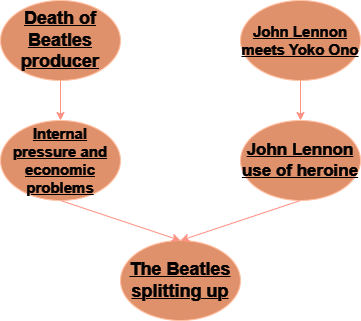

Let's first define the 5 nodes, the relations between them and the corresponding CPTs.

In [45]:
###################################################
#########  DEFINITION OF BEATLESCRASHNET  #########                    
###################################################


producer_death = Node(name="producer_death",
                        probabilities={
                            'Yes': 0.5,
                            'No': 0.5
                        }, order=0,
                        values=['Yes', 'No']
                        )
meeting_of_yoko = Node(name="meeting_of_yoko",
                       probabilities={
                            'Yes': 0.5,
                            'No': 0.5
                          }, order=0,
                            values=['Yes', 'No']
                        )

internal_pressure_economic_problems = Node(name="internal_pressure_economic_problems",
                                           parents=["producer_death"],
                                             probabilities=[{
                                                  ('Yes', 'Yes'): 0.6,
                                                  ('Yes', 'No'): 0.4
                                             }, {
                                                  ('No', 'Yes'): 0.1,
                                                  ('No', 'No'): 0.9
                                             }], order=1,
                                                values=['Yes', 'No']
                                            )

lennon_heroine_use = Node(name="lennon_heroine_use",
                            parents=["meeting_of_yoko"],
                            probabilities=[{
                                ('Yes', 'Yes'): 0.6,
                                ('Yes', 'No'): 0.4
                            }, {
                                ('No', 'Yes'): 0.1,
                                ('No', 'No'): 0.9
                            }], order=1,
                            values=['Yes', 'No']
                            )

beatles_breakup = Node(name="beatles_breakup",
                        parents=["internal_pressure_economic_problems", "lennon_heroine_use"],
                        probabilities=[
                            {('Yes', 'Yes', 'Yes'): 0.9,
                            ('Yes', 'Yes', 'No'): 0.1},
                            
                            {('Yes', 'No', 'Yes'): 0.7,
                            ('Yes', 'No', 'No'): 0.3},
                            
                            {('No', 'Yes', 'Yes'): 0.4,
                            ('No', 'Yes', 'No'): 0.6},
                            
                            {('No', 'No', 'Yes'): 0.1,
                            ('No', 'No', 'No'): 0.9}
                        ], order=2,
                        values=['Yes', 'No']
                        )

We can now compile the network and launch a few iterations of ancestral sampling!

In [46]:
BeatlesCrashNet = BayesianNetwork()

BeatlesCrashNet.add_node(producer_death)
BeatlesCrashNet.add_node(meeting_of_yoko)
BeatlesCrashNet.add_node(internal_pressure_economic_problems)
BeatlesCrashNet.add_node(lennon_heroine_use)
BeatlesCrashNet.add_node(beatles_breakup)

BeatlesCrashNet.run_ancestral_sampling(n_samples=3)

Sample number 1 : 
producer_death :  No
meeting_of_yoko :  No
internal_pressure_economic_problems :  No
lennon_heroine_use :  No
beatles_breakup :  No
Sample probability:  0.7290000000000001


Sample number 2 : 
producer_death :  Yes
meeting_of_yoko :  No
internal_pressure_economic_problems :  No
lennon_heroine_use :  No
beatles_breakup :  Yes
Sample probability:  0.036000000000000004


Sample number 3 : 
producer_death :  No
meeting_of_yoko :  Yes
internal_pressure_economic_problems :  No
lennon_heroine_use :  No
beatles_breakup :  No
Sample probability:  0.32400000000000007


Mean of joint probabilities:  0.36300000000000004


As we can see, if the band was a little bit stronger facing the serious problems that led to the big crash (indeed I made them a little bit stronger in the CPTs), we could still have the Beatles for a couple more years.  

Anyway, let's get back to it! 

## ENDRIGONET

This model is based and inspired by Sergio Endrigo's "Ci vuole un fiore" (1974), a classic italian song. 

_Per fare un tavolo ci vuole il legno,  
Per fare il legno ci vuole l'albero,  
Per fare l'albero ci vuole il seme,  
Per fare il seme ci vuole il frutto,  
Per fare il frutto ci vuole il fiore,  
Ci vuole un fiore, ci vuole un fiore.  
Per fare un tavolo ci vuole un fiore,  
Per fare un fiore ci vuole un ramo,  
Per fare il ramo ci vuole l'albero,  
Per fare l'albero ci vuole il bosco,    
Per fare il bosco ci vuole il monte,    
Per fare il monte ci vuol la terra,  
Per far la terra ci vuole un fiore,  
Per fare tutto ci vuole un fiore._  

In english it translates as:


_To make a table you need wood,  
To make wood you need the tree,  
To make the tree you need the seed,  
To make the seed you need the fruit,  
To make the fruit you need the flower,  
It takes a flower, it takes a flower.  
To make a table you need a flower,  
To make a flower you need a branch,  
To make the branch you need the tree,  
To make the tree you need the forest,  
To make the forest you need the mountain,  
To make the mountain you need the ground,  
To make the ground you need a flower,  
To make everything you need a flower._  

This song can be used to model the process of building a table! We can, for example, pretend to be a table industry.  
Obviously, this can't be turned into a Bayesian Network as it is.  
There is a cycle that we need to get rid of, in order to get a directed acyclic graph (DAG)!    
The problem is with trees. The tree appears at the bottom and at the top of the network! It's used to make wood and branches, which are already co-dependent. 
We just need to disambiguate between these trees. So, we can say that branches are made from cherry trees, and wood is made from pines. Easy!  
Also, let's ignore for the sake of simplicity the, although very joyous, _"To make everything you need a flower"_ and the metaphoric _"To make a table you need a flower"_. Let's stick to reality here! 

The new song is going to look like this:

_To make a table you need wood,  
To make wood you need the __pine tree__,  
To make the __pine tree__ you need the seed,  
To make the seed you need the fruit,  
To make the fruit you need the flower,  
It takes a flower, it takes a flower.    
To make a flower you need a branch,  
To make the branch you need __cherry tree__,  
To make the __pine tree__ you need the forest,  
To make the forest you need the mountain,  
To make the mountain you need the ground,  
To make the ground you need a flower._  

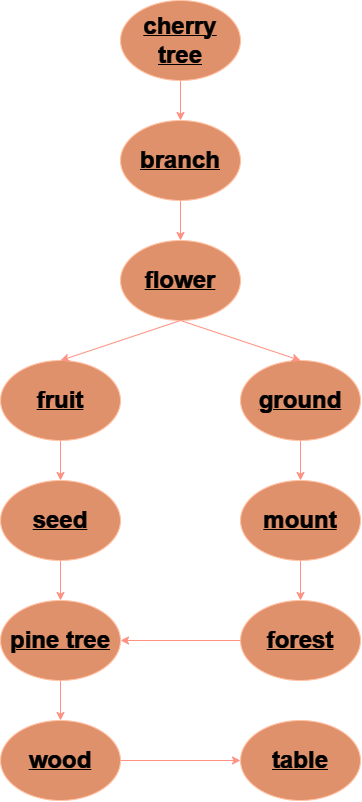

Now that the relations are defined, we can introduce EndrigoNet.  
The CPT for the root is just a dictionary, but for the children is a list of dictionaries.  
As we said, we are a table industry and we want to assess the quality of our table: will it be long lasting, fragile or broken?  
There are lots of conditioning factors for this, let's follow the (causal) topology:  
- `cherry_tree`: can either be young or old with equal probability.
- `branch`: can either be strong or weak, depending on the age of the `cherry_tree`. The younger the stronger, but without excluding strong branches from old cherry trees, which are kinda possible.
- `flower`: can either be a beautiful one or not. Here we have an Endrigoan '70s inspiration: we want to believe that beautiful things may come from poor conditions like weak branches. So the probability of this happening is not so dooming.
- `fruit`: can either be ripe or unripe. Again the Endrigoan '70s inspiration: good things can grow from "bad" things too, so unripe `fruit` from ugly flowers are more probable than we might think!
- `seed`: can either be fertile or not. Again, let's not be so dooming in the assignment of a infertile `seed` based on a ripe `fruit`. Let's stay positive, give it a 0.3 chance of being fertile.
- `ground`: can either be fertile or not. This one depends on the `flower` node, and we are keeping it Endrigoan: we are positive that the `ground` will probably be fertile, even with an ugly `flower`. Good things can grow from bad things too! 
- `mount`: can either be wooded, arid or artificial. Our industry cannot afford to have an arid `mount`. Let's keep that probability low, and if the `ground` is infertile we'll create an artificial `mount`. This is not so Endrigoan as we go a little against mother nature, but rememeber we're a table industry and we have got to make it somehow.
- `forest`: can either be thick or sparse. Of course an artificial `mount` can yield a thick `forest`, but we're not so advanced yet in the making of artificial environments so let's keep that probability a little bit lower than the natural `mount` case.
- `pine_tree`: can either be healthy or sick. This node depends on `seed` and `forest`, so have a slightly bigger CPT. We probably have a healthy pine tree if we have fertile seeds. Sparseness of the `forest` has a slightly lower impact on health.
- `wood`: can either be strong or weak. The CPT is pretty standard. 
- `table`: can either be long lasting, fragile or broken. Weak `wood` will probably create a fragile table, or worse, broken. Strong `wood` will probably yield a long lasting table. 

CPTs are briefly explained in the comments of the code too.

In [47]:
###################################################
#########    DEFINITION OF ENDRIGONET     #########                    
###################################################

# cherry_tree is the root node. It has two possible values: Young and Old. Each value has the same probability.
cherry_tree = Node(name="cherry_tree", 
                   probabilities={
                       'Young': 0.5,
                       'Old': 0.5
                   }, order = 0,
                   values = ['Young', 'Old']
                )
# branch is a child of cherry_tree. It has two possible values: Strong and Weak.
# The probability of the branch being Strong is 0.7 if the cherry_tree is Young. This seems reasonable because young trees are usually stronger.
# The probability of the branch being Strong is 0.2 if the cherry_tree is Old. This seems reasonable because old trees are usually weaker.
branch = Node(name="branch",
              parents=["cherry_tree"],
              probabilities=[{
                  ('Young', 'Strong'): 0.7,
                  ('Young', 'Weak'): 0.3
              },
                  {
                      ('Old', 'Strong'): 0.2,
                      ('Old', 'Weak'): 0.8
                  }], order=1,
              values=['Strong', 'Weak']
            )
# flower is a child of branch. It has two possible values: Beautiful and Ugly.
# The probability of the flower being Beautiful is 0.9 if the branch is Strong. This seems reasonable because strong branches are usually healthier.
# The probability of the flower being Beautiful is 0.3 if the branch is Weak. This seems reasonable because weak branches are usually less healthy, but we can still have some beautiful flowers.
flower = Node(name="flower",
              parents=["branch"],
              probabilities=[{
                  ('Strong', 'Beautiful'): 0.9,
                  ('Strong', 'Ugly'): 0.1
              }, {
                  ('Weak', 'Beautiful'): 0.3,
                  ('Weak', 'Ugly'): 0.7
              }], order=2,
              values=['Beautiful', 'Ugly'])
# fruit is a child of flower. It has two possible values: Ripe and Unripe.
# The probability of the fruit being Ripe is 0.1 if the flower is Beautiful. This seems reasonable because beautiful flowers are usually healthier. Endrigo would agree with this, as he agrees that bad things can't grow from good things.
# The probability of the fruit being Ripe is 0.4 if the flower is Ugly. This seems reasonable because ugly flowers are usually less healthy. But we are still on the good side, as we're optimistic that good things can grow from bad things.
fruit = Node(name="fruit",
             parents=["flower"],
             probabilities=[{
                 ('Beautiful', 'Ripe'): 0.1,
                 ('Beautiful', 'Unripe'): 0.9
             }, {
                 ('Ugly', 'Ripe'): 0.4,
                 ('Ugly', 'Unripe'): 0.6
             }],order=3,
             values=['Ripe', 'Unripe'])
# seed is a child of fruit. It has two possible values: Fertile and Infertile.
# The probability of the seed being Infertile is 0.7 if the fruit is Ripe. This seems reasonable because ripe fruits usually have infertile seeds.
# The probability of the seed being Fertile is 0.8 if the fruit is Unripe. This seems reasonable because unripe fruits usually have fertile seeds.
seed = Node(name="seed",
            parents=["fruit"],
            probabilities=[{
                ('Ripe', 'Fertile'): 0.3,
                ('Ripe', 'Infertile'): 0.7
            }, {
                ('Unripe', 'Fertile'): 0.8,
                ('Unripe', 'Infertile'): 0.2
            }],order=4,
            values=['Fertile', 'Infertile'])
# ground is a child of flower. It has two possible values: Fertile and Infertile.
# The probability of the ground being Fertile is 0.8 if the flower is Beautiful. This seems reasonable because beautiful flowers usually grow in fertile ground. And also Endrigo seems quite sure about this one.
# The probability of the ground being Fertile is 0.4 if the flower is Ugly. This seems reasonable because ugly flowers usually grow in infertile ground. But we are still on the good side, as we're optimistic that good things can grow from "bad" things.
ground = Node(name="ground",
                     parents=["flower"],
                     probabilities=[{
                         ('Beautiful', 'Fertile'): 0.8,
                         ('Beautiful', 'Infertile'): 0.2
                     }, {
                         ('Ugly', 'Fertile'): 0.6,
                         ('Ugly', 'Infertile'): 0.4
                     }],order=3,
                     values=['Fertile', 'Infertile'])
# mount is a child of ground. It has three possible values: Wooded, Arid, and Artificial.
# Here there's a twist. If we have fertile ground, we have a higher probability of having a wooded mount. 
# But if we have infertile ground, we have a higher probability of having an artificial mount. We don't want our table industry to fail!
# Arid mounts are not very common, but they can still happen. We have a small probability of having an arid mount, regardless of the fertility of the ground. This is for when we've given up on the table industry.
mount = Node(name="mount",
             parents=["ground"],
             probabilities=[{
                 ('Fertile', 'Wooded'): 0.8,
                 ('Fertile', 'Arid'): 0.05,
                 ('Fertile', 'Artificial'): 0.15
             }, {
                 ('Infertile', 'Wooded'): 0.15,
                 ('Infertile', 'Arid'): 0.05,
                 ('Infertile', 'Artificial'): 0.8
             }],order=4,
             values=['Wooded', 'Arid', 'Artificial'])
# forest is a child of mount. It has two possible values: Thick and Sparse.
# With wooded mounts we have a higher probability of having a thick forest. 
# With artificial mounts we have a slightly higher probability of having a sparse forest. 
# With arid mounts, we almost surely have a sparse forest. Remember here we've sadly given up on the table industry.
forest = Node(name="forest",
              parents=["mount"],
              probabilities=[{
                  ('Wooded', 'Thick'): 0.8,
                  ('Wooded', 'Sparse'): 0.2
              }, {
                  ('Arid', 'Thick'): 0.1,
                  ('Arid', 'Sparse'): 0.9
              }, {
                  ('Artificial', 'Thick'): 0.7,
                  ('Artificial', 'Sparse'): 0.3
                  }],order=5,
              values=['Thick', 'Sparse'])
# pine_tree is a child of seed and forest. It has two possible values: Healthy and Sick.
# We probably have a healthy pine tree if we have fertile seeds.
# Sparseness of the forest has a slightly lower impact on the health of the pine tree. 
pine_tree = Node(name="pine_tree",
                 parents=["seed", "forest"],
                 probabilities=[
                     {('Fertile', 'Thick', 'Healthy'): 0.8,
                      ('Fertile', 'Thick', 'Sick'): 0.2},
                     
                     {('Fertile', 'Sparse', 'Healthy'): 0.7,
                      ('Fertile', 'Sparse', 'Sick'): 0.3},
                     
                     {('Infertile', 'Thick', 'Healthy'): 0.5,
                      ('Infertile', 'Thick', 'Sick'): 0.5},
                     
                     {('Infertile', 'Sparse', 'Healthy'): 0.2,
                      ('Infertile', 'Sparse', 'Sick'): 0.8}
                 ],order=6,
                 values=['Healthy', 'Sick'])
# wood is a child of pine_tree. It has two possible values: Strong and Weak.
# We probably have strong wood if we have a healthy pine tree.
wood = Node(name="wood",
            parents=["pine_tree"],
            probabilities=[{
                ('Healthy', 'Strong'): 0.8,
                ('Healthy', 'Weak'): 0.2
            }, {
                ('Sick', 'Strong'): 0.2,
                ('Sick', 'Weak'): 0.8
            }],order=7,
            values=['Strong', 'Weak'])
# table is a child of wood. It has three possible values: Long Lasting, Fragile, and Broken.
# We probably have a long-lasting table if we have strong wood. There are still chances of having a fragile or broken table, but they are very low.
# We probably have a fragile table if we have weak wood. There are still chances of having a long-lasting table, but they are very low. More likely, we have a broken table.
table = Node(name="table",
             parents=["wood"],
             probabilities=[{
                 ('Strong', 'Long Lasting'): 0.7,
                 ('Strong', 'Fragile'): 0.18,
                 ('Strong', 'Broken'): 0.12
             }, {
                 ('Weak', 'Long Lasting'): 0.1,
                 ('Weak', 'Fragile'): 0.6,
                 ('Weak', 'Broken'): 0.3
             }],order=8,
             values=['Long Lasting', 'Fragile', 'Broken'])

Here we simply create an instance of a `BayesianNetwork()` and add all the previously defined nodes with `add_node` method. Note that here order of insertion doesn't matter as the topology is defined in the `Node` class.

In [48]:
###################################################
#########       NETWORK COMPILATION       #########                    
###################################################

# Initialize the network
EndrigoNet = BayesianNetwork()

# Add nodes to the network in whatever order (topology and causal ordering are preserved)
EndrigoNet.add_node(cherry_tree)
EndrigoNet.add_node(branch)
EndrigoNet.add_node(flower)
EndrigoNet.add_node(fruit)
EndrigoNet.add_node(seed)
EndrigoNet.add_node(ground)
EndrigoNet.add_node(mount)
EndrigoNet.add_node(forest)
EndrigoNet.add_node(pine_tree)
EndrigoNet.add_node(wood)
EndrigoNet.add_node(table)

Finally, we can run as many iterations of ancestral sampling as we want through the `run_ancestral_sampling(n_samples)` method. 

In [49]:
# Generate 100 samples from the network and calculate the mean and standard deviation of the joint probability of the samples
EndrigoNet.run_ancestral_sampling(n_samples=10)

Sample number 1 : 
cherry_tree :  Old
branch :  Strong
flower :  Beautiful
fruit :  Unripe
ground :  Fertile
seed :  Fertile
mount :  Wooded
forest :  Thick
pine_tree :  Sick
wood :  Weak
table :  Long Lasting
Sample probability:  0.0010616832000000006


Sample number 2 : 
cherry_tree :  Old
branch :  Weak
flower :  Beautiful
fruit :  Unripe
ground :  Fertile
seed :  Fertile
mount :  Wooded
forest :  Thick
pine_tree :  Healthy
wood :  Weak
table :  Broken
Sample probability:  0.004246732800000001


Sample number 3 : 
cherry_tree :  Old
branch :  Weak
flower :  Ugly
fruit :  Unripe
ground :  Fertile
seed :  Fertile
mount :  Wooded
forest :  Thick
pine_tree :  Sick
wood :  Weak
table :  Fragile
Sample probability:  0.0099090432


Sample number 4 : 
cherry_tree :  Old
branch :  Weak
flower :  Ugly
fruit :  Unripe
ground :  Infertile
seed :  Fertile
mount :  Wooded
forest :  Thick
pine_tree :  Healthy
wood :  Weak
table :  Fragile
Sample probability:  0.0012386304


Sample number 5 : 
cher

## Conclusions

As we can see the joint probabilities are very low, this is naturally caused by the amount of nodes in the network and by the many low probabilities in the CPTs. When we multiply these 11 small numbers, we get a very small number, which is not so indicative nor useful, on the other hand I found that "spiking" and very penalizing probabilities such as 0.9 and 0.1, when combined in a long series of events, influenced a lot the final joint probability making it infinitesimaly small, so I decided to smooth some values a little. Also I have to say that the probabilities were not all driven by a realistic inspiration, some were intentionally biased by an overoptimistic spirit in the good name of 70's Sergio Endrigo, but this was just a fun experiment afterall ! I think that a lot of efficiency improvements are possible, for example I could have used a different way to store the CPTs values, given that much of the present information is redundant, but I had a lot of fun implementing and modeling these processes. One that I had in mind but never made it was based on how to win the Turing prize... and many more popped in my mind when thinking about causal relationships. One interesting aspect was the topology ordering: I thought about an automatic way to find it examining the children's presence or the parents' identities, but I felt that giving the user the explicit possibility to express it was a lot better for flexibility and problem understanding. Special thanks to Sergio Endrigo! 